In [12]:
from typing import Optional, Tuple, Dict, Any, Union, cast, TypeVar, Callable
import subprocess
import logging
from matplotlib import font_manager, rc_context
from matplotlib.ticker import EngFormatter
from matplotlib.figure import Figure
from matplotlib.axes import Axes
import pandas as pd
from PIL import Image
import datetime
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def _init_custom_fonts(font_dir: str) -> None:
    custom_font_files = font_manager.findSystemFonts(fontpaths=font_dir)
    mgr = font_manager.fontManager
    for f in custom_font_files:
        mgr.addfont(f)


_init_custom_fonts("fonts")


_F = TypeVar("_F", bound=Callable[..., Any])


def with_custom_rc(rc: Dict[str, Any]) -> Callable[[_F], _F]:
    def inner(func: _F) -> _F:
        def wrapper(*args: Any, **kwargs: Any) -> Any:
            with rc_context(rc=rc):
                return func(*args, **kwargs)

        return cast(_F, wrapper)

    return inner


def apply_fig_style(fig: Figure) -> None:
    fig.set(
        figwidth=12,
        figheight=6,
        dpi=200,
        edgecolor="#dddddd",
        linewidth=4,
        tight_layout=True,
    )


def apply_ax_style(ax: Axes, grid: bool = True) -> None:
    ax.set(facecolor="w")
    for s in ax.spines:
        ax.spines[s].set_color("#dddddd")
    if grid:
        ax.grid(True, axis="y", color="#dddddd", alpha=0.9)
    ax.title.set(x=0, y=1.04, fontsize=16, ha="left", va="baseline")
    ax.xaxis.label.set(fontsize=12)
    ax.yaxis.label.set(fontsize=12)
    ax.tick_params(
        axis="x", colors="#dddddd", which="both", labelcolor="k", labelsize=10
    )
    ax.tick_params(
        axis="y", colors="#dddddd", which="both", labelcolor="k", labelsize=10
    )


def save_fig_with_watermark(
    fig: Figure,
    dest_file: str,
    ax: Optional[Axes] = None,
    timestamp: Optional[pd.Timestamp] = None,
) -> None:
    if timestamp is None:
        timestamp = pd.Timestamp.utcnow().replace(tzinfo=None)
    if ax is not None:
        apos = ax.get_position()

        ax.text(
            0,
            -0.11,
            "Based on data from " + timestamp.strftime("%Y-%m-%d"),
            ha="left",
            va="baseline",
            fontsize=12,
            c="0.5",
            transform=ax.transAxes,
        )
        ax.text(
            1,
            -0.11,
            "© {} Glassnode. All Rights Reserved.".format(timestamp.strftime("%Y")),
            ha="right",
            va="baseline",
            fontsize=12,
            c="0.5",
            transform=ax.transAxes,
        )

    dpi = 200
    fig.savefig(dest_file, dpi=dpi)

    # Watermark position
    w, h = fig.get_size_inches()
    w = w * dpi
    h = h * dpi

    if ax is None:
        wm_center_x = int(w // 2)
        wm_center_y = int(h // 2)
    else:
        ax_center_x_rel = (apos.x1 + apos.x0) / 2
        ax_center_y_rel = (apos.y1 + apos.y0) / 2
        wm_center_x = int(ax_center_x_rel * w)
        wm_center_y = int(ax_center_y_rel * h)

    _add_watermark(dest_file, (wm_center_x, wm_center_y))

    # Shrink file size
    try:
        p = subprocess.run(["optipng", dest_file], capture_output=True)
    except FileNotFoundError:
        logging.warning('Could not find "optipng" to shrink file size')
    else:
        if p.returncode != 0:
            logging.warning(
                "Optipng failed. Output: {}".format(p.stderr.decode("utf-8"))
            )


def _add_watermark(imagefile: str, pos_center: Tuple[int, int]) -> None:
    image = Image.open(imagefile).convert("RGBA")

    # Load, prepare and paste watermark
    logo = Image.open("glassnode_large.png").convert("RGBA")
    new_size = logo.width * 2, logo.height * 2
    logo = logo.resize(new_size, resample=Image.LANCZOS)
    R, G, B, A = logo.split()
    A.putdata(A.getdata(), scale=0.3)
    logo = Image.merge("RGBA", [R, G, B, A])

    pos_x = pos_center[0] - logo.width // 2
    pos_y = pos_center[1] - logo.height // 2
    image.paste(logo, (pos_x, pos_y), logo)

    # Flatten
    background = Image.new("RGBA", image.size, (255, 255, 255))
    image = Image.alpha_composite(background, image)

    image.convert("RGB").save(imagefile)


class EngDollarFormatter(EngFormatter):
    def __init__(self) -> None:
        super(EngDollarFormatter, self).__init__(sep="")
        self.ENG_PREFIXES: Dict[int, str] = {
            0: "",
            3: "k",
            6: "m",
            9: "b",
            12: "t",
        }

    def format_eng(self, num: Union[int, float]) -> str:
        eng: str = super(EngDollarFormatter, self).format_eng(num)
        minus_signs = ["-", "\N{MINUS SIGN}"]
        for minus_sign in minus_signs:
            if eng.startswith(minus_sign):
                return minus_sign + "$" + eng[len(minus_sign) :]
        return "$" + eng


## Sample plot

You're plot has been saved to plot_with_watermark_matplotlib.png


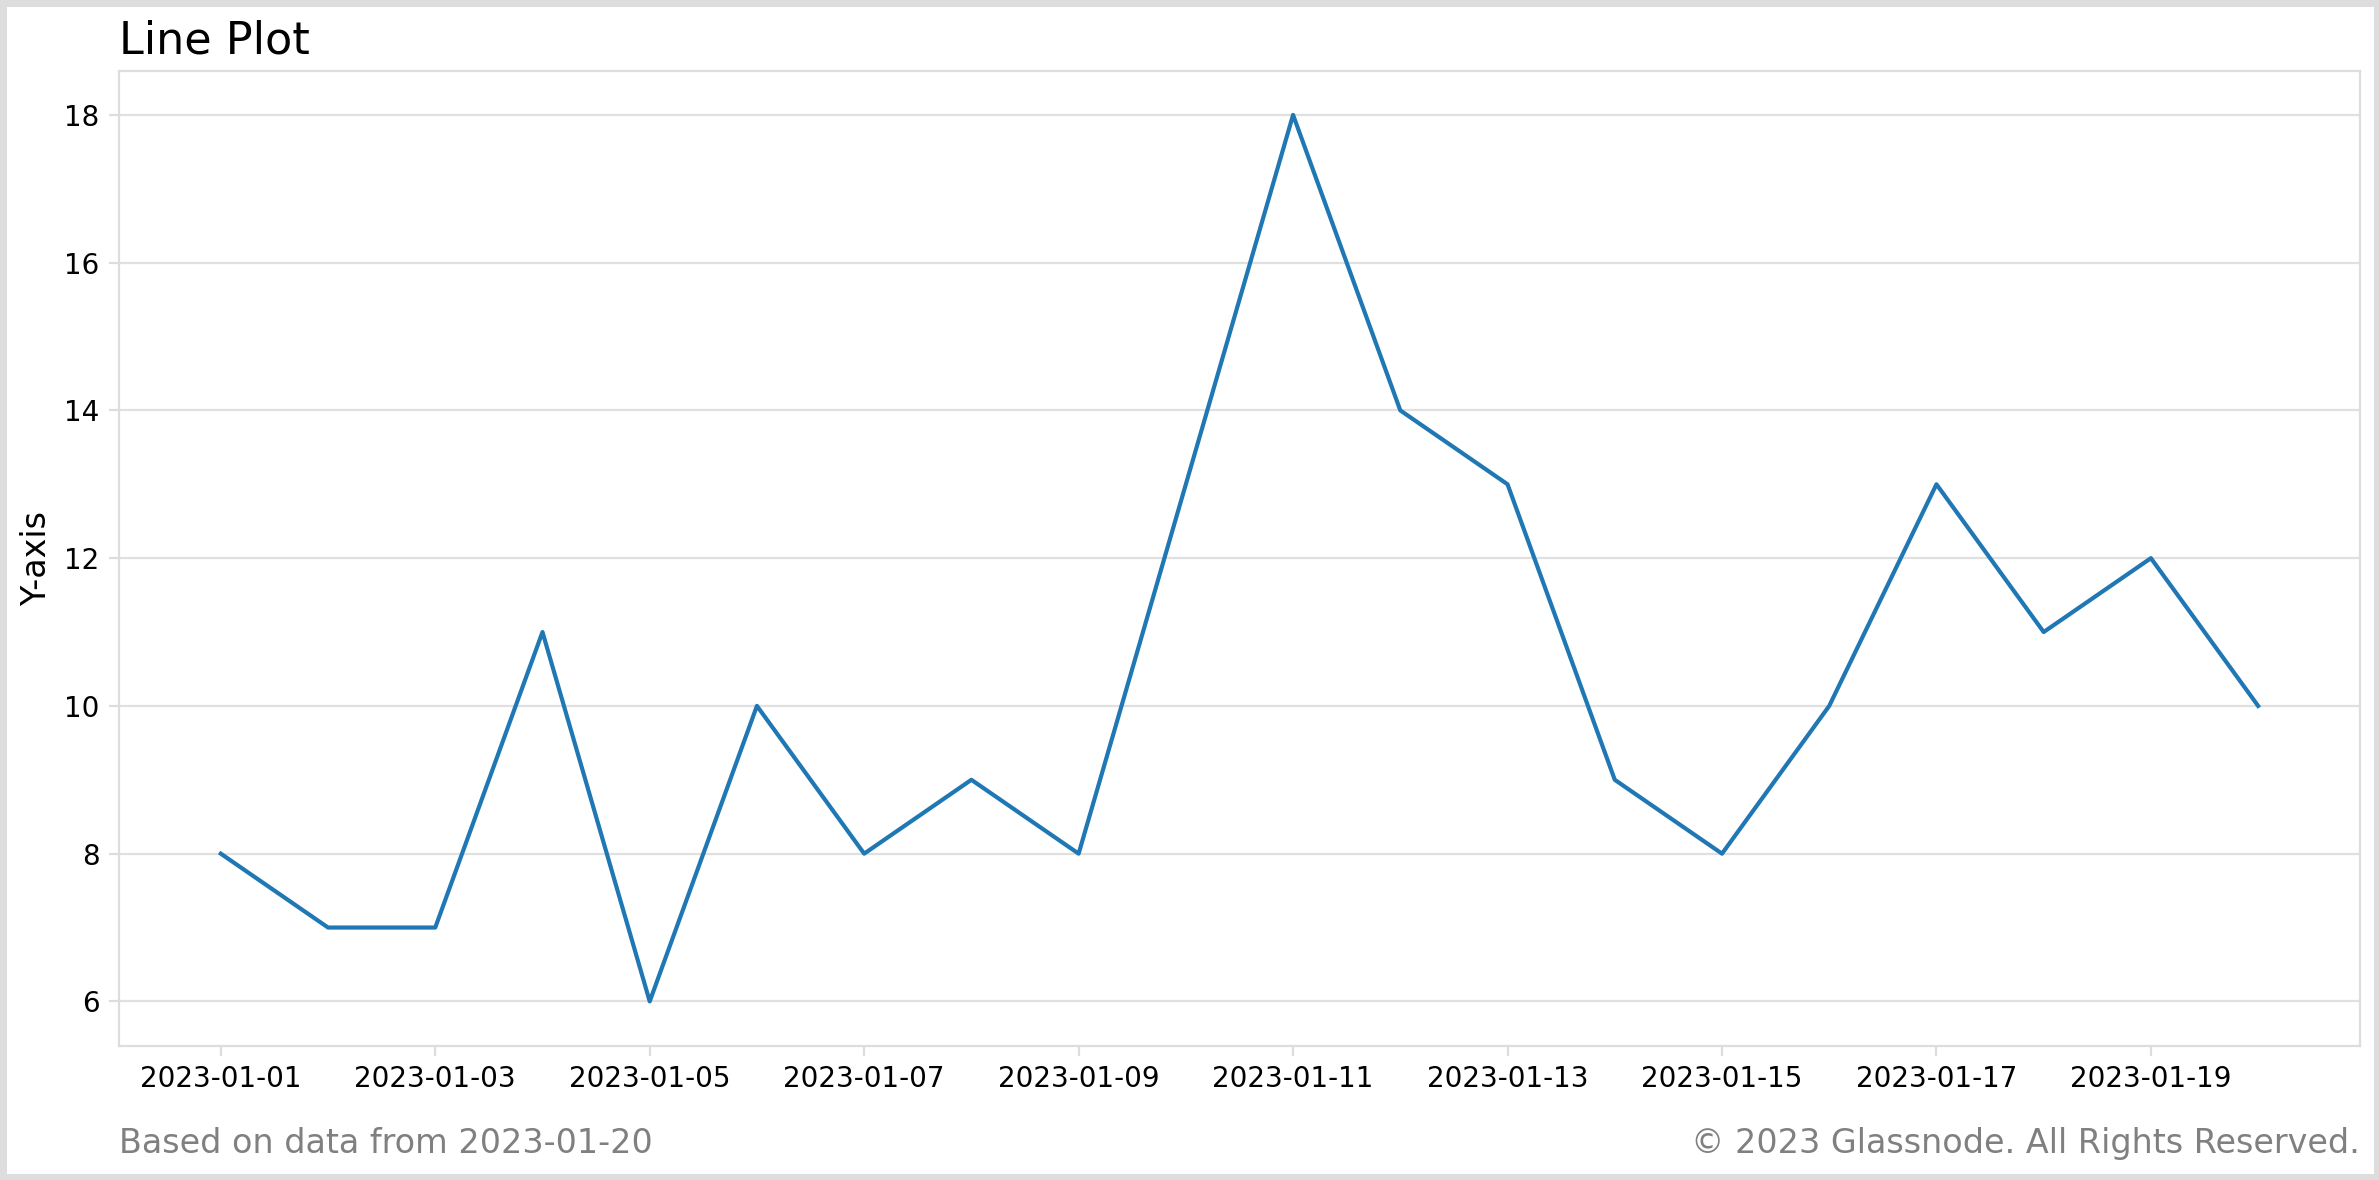

In [13]:
# Generate random data for the line plot
num_points = 20  # Number of data points
start_date = datetime(2023, 1, 1)  # Start date for the X-axis

x_data = [start_date]
y_data = [random.randint(1, 10)]

for i in range(1, num_points):
    x_data.append(x_data[i - 1] + timedelta(days=1))
    y_data.append(y_data[i - 1] + random.randint(-5, 5))

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the data
ax.plot(x_data, y_data)

# Customize the plot layout
ax.set_title('Line Plot')
#ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Format x-axis to display dates
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Add y-axis grid
#ax.grid(axis='y')

# Add watermarks
apply_fig_style(fig)
apply_ax_style(ax)
#apply_ax_style(ax2, grid=False)

dest_filename = "plot_with_watermark_matplotlib.png"
save_fig_with_watermark(
    fig,
    dest_filename,
    ax=ax,
    timestamp=pd.to_datetime(x_data[-1]),
)

print("You're plot has been saved to " + dest_filename)
# plt.show()
